The cell below imports all the required libraries and defines key variables. You'll have to run cells one at a time from top to bottom. If you run them out of order, things won't work.

This notebook will closely follow the tutorial here - https://docs.lightkurve.org/tutorials/1-getting-started/what-are-lightcurve-objects.html.

In [14]:
# Make plots in the notebook so you can see them.
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import lightkurve # Import the lightkurve library
from lightkurve import search_targetpixelfile # From the lightkurve library, import the search_targetpixelfile method.

In [9]:
# Give your planet name - be sure to spell everything exactly right. Otherwise, the package won't find the data.
planet_name = "XO-1"

# Open a Target Pixel File from MAST and download one data file.
tpf = search_targetpixelfile(planet_name).download()

# Then we convert the target pixel file into a light curve using the pipeline-defined aperture mask.
lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)
print(lc) # You should see a table of data below that looks like (but not exactly like) the pasted text below.
#  time            flux          flux_err     ... cadenceno quality
#                    electron / s    electron / s   ...                  
# ------------------ ------------ ----------------- ... --------- -------
# 120.52924274596444 401333.15625 91.52275085449219 ...      5500       0

       time              flux           flux_err      ... cadenceno quality
                     electron / s     electron / s    ...                  
------------------ --------------- ------------------ ... --------- -------
1955.7990267537568 9087.6220703125  12.76364517211914 ...    524405       0
1955.8004156718298    9094.9296875 12.802447319030762 ...    524406       0
1955.8018045901358 9065.2783203125 12.754873275756836 ...    524407       0
 1955.803193508209  9066.900390625   12.7570161819458 ...    524408       0
 1955.804582426282 9066.4423828125 12.756695747375488 ...    524409       0
 1955.805971344355 9077.1083984375 12.761527061462402 ...    524410       0
               ...             ...                ... ...       ...     ...
1982.2757545071158 9052.1884765625 12.730691909790039 ...    543468       0
1982.2771433958524  9067.294921875 12.760944366455078 ...    543469       0
1982.2785322841232  9049.568359375 12.730385780334473 ...    543470       0
1982.2799211

/Users/brian/opt/anaconda3/envs/PHYS305_Observing_Project/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Let's start by plotting your data. As a general rule, you should always inspect any data you intend to use and do NOT just assume the data are fine.

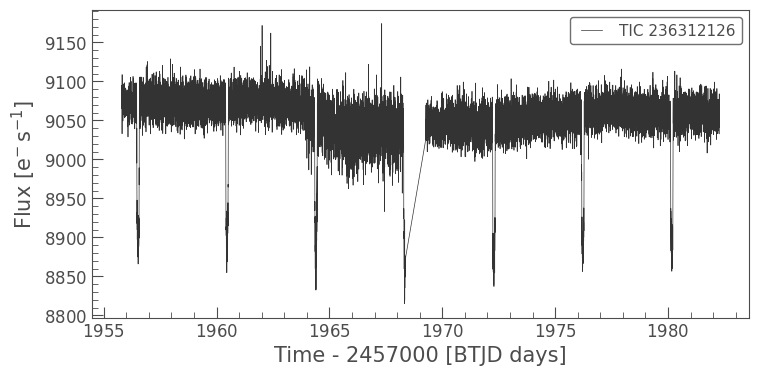

In [10]:
lc.plot();

Hopefully, what you see above is a series of transit dips, probably with some scatter. 

In some cases, you may also see individual points with excursions unassociated with the transit dips, which we'll call "single-point outliers". 

There may also be some up-and-down wobbles unassocated with the transit dips. We'll call these signals "systematic noise".

In order to conduct our transit analysis, we will need to remove as much of those sources of noise as possible. 

---

### Removing Single-Point Outliers

Since the single-point outliers are big, discrete jumps, we can try to find them by using the technique we talked about in class before: calculating the derivative of the time-series and then looking for big outlier values.

(array([2.000e+00, 1.600e+01, 2.430e+02, 2.842e+03, 9.344e+03, 5.166e+03,
        5.590e+02, 3.800e+01, 5.000e+00, 1.000e+00]),
 array([-137.26464844, -107.85380554,  -78.44297028,  -49.03212738,
         -19.6212883 ,    9.78955078,   39.20038986,   68.61122894,
          98.02207184,  127.4329071 ,  156.84375   ]),
 <BarContainer object of 10 artists>)

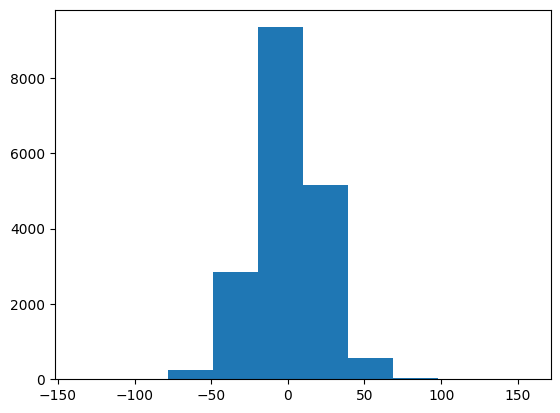

In [15]:
# Calculate the derivative
df = np.diff(lc['flux'])

plt.hist(df)